# Nintendo Game & Watch: Data Visualizations

The goal of this project is to explore the Nintendo Game & Watch dataset through visualizations. These visualizations provide an easy and intuitive way for retro game collectors to gain insights and a deeper understanding of the evolution and impact of Nintendo Game & Watch over time.

## Exploratory Data Analysis (EDA)

This notebook follows the six practices of EDA by Google: discovering, structuring, cleaning, joining, validating, and presenting. Note that the six practices of EDA are iterative and non-sequential, so the order used in this notebook may differ from the above.

### 1 - Discovering

#### Imports

In [1]:
# Standard library modules
import datetime as dt
import math
import pathlib
import re
from typing import Union

# Third-party modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

# First-party modules
from utils import (
    generate_timeline_levels,
    get_timeline_levels,
    visualize_games_produced,
    visualize_games_released,
    visualize_outliers,
    visualize_series_produced,
    visualize_timeline,
)

#### Datasets

In [2]:
# Nintendo Game & Watch dataset
dataset_filepath = pathlib.Path("data/nintendo_game_and_watch.csv")
df = pd.read_csv(dataset_filepath)

#### First look at the data

In [3]:
df.head(10)

,game,series,model,acronyms,date of release,release order,produced,rarity,battery,description
0,Ball,Silver,AC-01,"ACrobat, ACtion","April 28, 1980",1,250 000,VR,2 x LR-43 (or SR-43),Your task is to control the hands of a juggler...
1,Flagman,Silver,FL-02,"FLag, FLagman","June 5, 1980",2,250 000,XR,2 x LR-43 (or SR-43),Simon type of game. You have to repeat the seq...
2,Vermin,Silver,MT-03,"Mogura Tataki, Mole Tunnel","July 10, 1980",3,500 000,R,2 x LR-43 (or SR-43),Hit the moles as they surface from the tunnels.
3,Fire,Silver,RC-04,ResCue,"July 31, 1980",4,1 000 000,R,2 x LR-43 (or SR-43),You control two guys with a stretcher (which a...
4,Judge,Silver,IP-05,"ImPact, InterPret","October 4, 1980",5,250 000,XR,2 x LR-43 (or SR-43),Hit your opponent with a hammer or avoid his h...
5,Manhole,Gold,MH-06,ManHole,"January 29, 1981",6,500 000,R,2 x LR-43 (or SR-43),Your task is to save passersby from falling in...
6,Helmet,Gold,CN-07,CoNstruction,"February 21, 1981",7,500 000,R,2 x LR-43 (or SR-43),Reach the shed while avoiding falling objects.
7,Lion,Gold,LN-08,LioN,"April 29, 1981",8,250 000,R,2 x LR-43 (or SR-43),You control two tamers who try to stop the lio...
8,Parachute,Wide Screen,PR-21,PaRachute,"June 19, 1981",9,1 200 000,VC,2 x LR-43 (or SR-43),Save as many paratroopers as you can with your...
9,Octopus,Wide Screen,OC-22,OCtopus,"July 16, 1981",10,1 200 000,VC,2 x LR-43 (or SR-43),Get the treasure and avoid octopus' tentacles.


#### Summary information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   game             63 non-null     object
 1   series           63 non-null     object
 2   model            63 non-null     object
 3   acronyms         63 non-null     object
 4   date of release  63 non-null     object
 5   release order    63 non-null     int64 
 6   produced         63 non-null     object
 7   rarity           63 non-null     object
 8   battery          63 non-null     object
 9   description      63 non-null     object
dtypes: int64(1), object(9)
memory usage: 5.0+ KB


#### Descriptive statistics

In [5]:
df.describe()

,release order
count,63.000000
mean,32.000000
std,18.330303
min,1.000000
25%,16.500000
50%,32.000000
75%,47.500000
max,63.000000


### 2 - Cleaning

#### Duplicates

In [6]:
# Check for duplicates
n_duplicate_rows = df.duplicated().sum()
n_rows = len(df)
print(f"Duplicate rows: {n_duplicate_rows} ({(n_duplicate_rows / n_rows):.2%})")

Duplicate rows: 0 (0.00%)


The dataset does not have any duplicates.

#### Missing values

In [7]:
# Check for missing values
df.isna().sum()

game               0
series             0
model              0
acronyms           0
date of release    0
release order      0
produced           0
rarity             0
battery            0
description        0
dtype: int64

The dataset does not have any missing values.

#### Data types

In [8]:
# Convert "produced" values to numeric
df["produced"] = df["produced"].replace("Unknown", np.nan)  # replace "Unknown" values with NaN
df["produced"] = df["produced"].str.replace(" ", "").astype("Int64")  # remove all whitespaces and convert the type

In [9]:
# Convert "rarity" values to numeric (ordinal)
rarity_dict = {
    "XC": 1,
    "VC": 2,
    "C": 3,
    "UC": 4,
    "R": 5,
    "VR": 6,
    "XR": 7,
}
df["rarity"] = df["rarity"].map(rarity_dict)

In [10]:
# Convert "date of release" values to datetime
df["date of release"] = pd.to_datetime(df["date of release"])

In [11]:
# Check data types
df.dtypes

game                       object
series                     object
model                      object
acronyms                   object
date of release    datetime64[ns]
release order               int64
produced                    Int64
rarity                      int64
battery                    object
description                object
dtype: object

#### Outliers

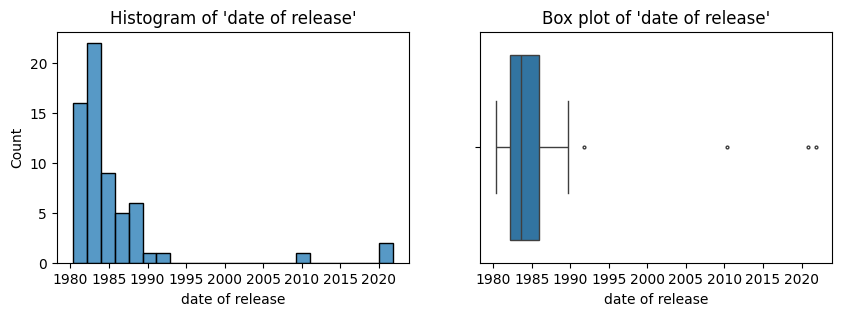

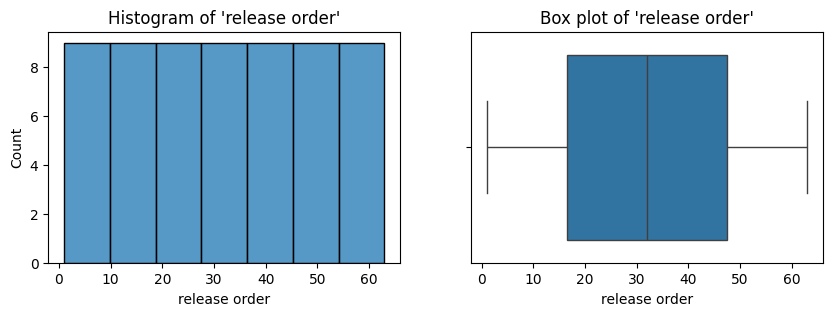

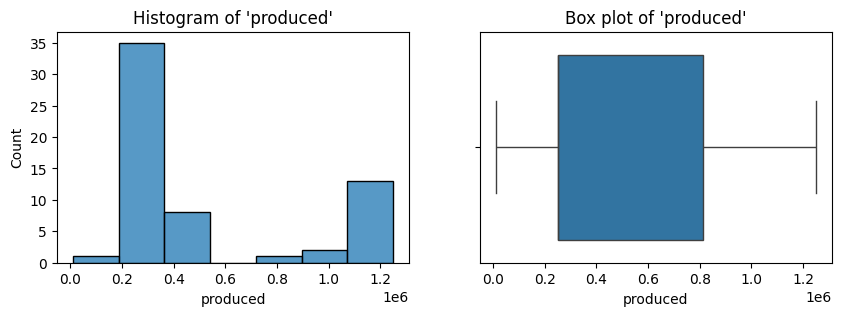

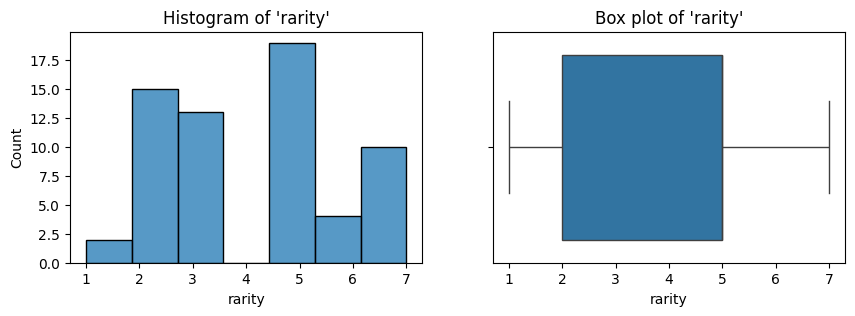

In [12]:
# Create histogram and box plot visualizations for each column to check for outliers
for column_name in ["date of release", "release order", "produced", "rarity"]:
    visualize_outliers(df, column_name)

The `date of release` column has some outliers in the 2000s. However, these values are correct.

### 3 - Structuring

#### Series

In [13]:
# Create a series data frame
series_df = df.copy()
series_df = series_df.groupby(["series"]).agg(
    from_date=pd.NamedAgg(column="date of release", aggfunc="min"),
    to_date=pd.NamedAgg(column="date of release", aggfunc="max"),
    games=pd.NamedAgg(column="series", aggfunc="count"),
    produced=pd.NamedAgg(column="produced", aggfunc="sum")
).sort_values(by="from_date").reset_index()
series_df["from"] = series_df["from_date"].dt.year
series_df["to"] = series_df["to_date"].dt.year
series_df = series_df.drop(["from_date", "to_date"], axis=1)
series_df

,series,games,produced,from,to
0,Silver,5,2250000,1980,1980
1,Gold,3,1250000,1981,1981
2,Wide Screen,10,8950000,1981,1982
3,Multi Screen,15,10250000,1982,1989
4,New Wide Screen,8,4200000,1982,1991
5,Table Top,4,1000000,1983,1983
6,Panorama Screen,6,1500000,1983,1984
7,Super Color,2,500000,1984,1984
8,Micro VS. System,3,750000,1984,1984
9,Crystal Screen,3,750000,1986,1986


#### Games

In [14]:
# Create a games data frame
games_df = df.copy()
games_df = games_df.drop(["acronyms", "rarity", "battery", "description"], axis=1)
games_df = games_df.sort_values(by="release order", ascending=True).reset_index(drop=True)
games_df

,game,series,model,date of release,release order,produced
0,Ball,Silver,AC-01,1980-04-28,1,250000
1,Flagman,Silver,FL-02,1980-06-05,2,250000
2,Vermin,Silver,MT-03,1980-07-10,3,500000
3,Fire,Silver,RC-04,1980-07-31,4,1000000
4,Judge,Silver,IP-05,1980-10-04,5,250000
...,...,...,...,...,...,...
58,Zelda,Multi Screen,ZL-65,1989-08-26,59,250000
59,Mario the Juggler,New Wide Screen,MB-108,1991-10-14,60,250000
60,Ball,Reissue,RGW-001,2010-04-28,61,<NA>
61,Super Mario Bros.,Colour Screen,HXA-001,2020-11-13,62,<NA>


#### Games released

In [15]:
# Create a games released data frame
games_released_df = df.copy()
games_released_df = games_released_df.groupby(games_released_df["date of release"].dt.year).agg(
    games=pd.NamedAgg(column="game", aggfunc="count"),
).sort_values(by="date of release").reset_index()
games_released_df = games_released_df.rename(columns={"date of release": "year"})
games_released_df

,year,games
0,1980,5
1,1981,10
2,1982,8
3,1983,15
4,1984,7
5,1985,2
6,1986,4
7,1987,2
8,1988,5
9,1989,1


### 4 - Validating

#### Series

In [16]:
# Check for duplicates
series_df.duplicated().any()

False

In [17]:
# Check for missing values
series_df.isna().any()

series      False
games       False
produced    False
from        False
to          False
dtype: bool

In [18]:
# Check data types
series_df.dtypes

series      object
games        int64
produced     Int64
from         int32
to           int32
dtype: object

#### Games

In [19]:
# Check for duplicates
games_df.duplicated().any()

False

In [20]:
# Check for missing values
games_df.isna().any()

game               False
series             False
model              False
date of release    False
release order      False
produced            True
dtype: bool

In [21]:
# Check data types
games_df.dtypes

game                       object
series                     object
model                      object
date of release    datetime64[ns]
release order               int64
produced                    Int64
dtype: object

#### Games released

In [22]:
# Check for duplicates
games_released_df.duplicated().any()

False

In [23]:
# Check for missing values
games_released_df.isna().any()

year     False
games    False
dtype: bool

In [24]:
# Check data types
games_released_df.dtypes

year     int32
games    int64
dtype: object

### 5 - Presenting

#### Series produced

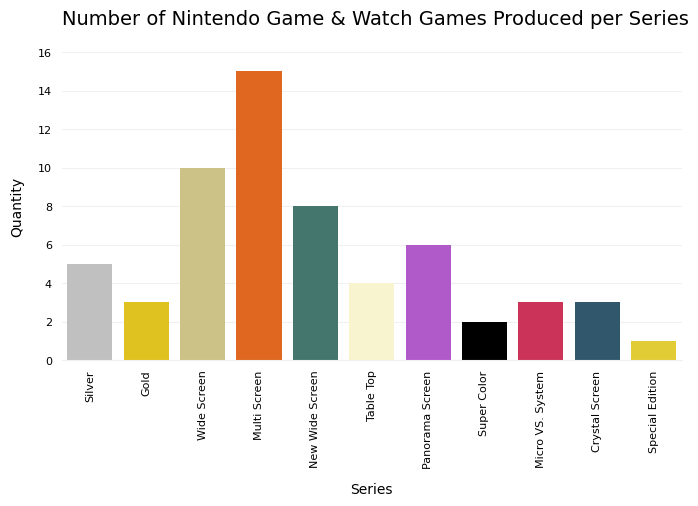

In [25]:
# Create a bar plot visualization showing the number of games produced per series
visualize_series_produced(series_df, max_release_year=1991)

#### Games produced

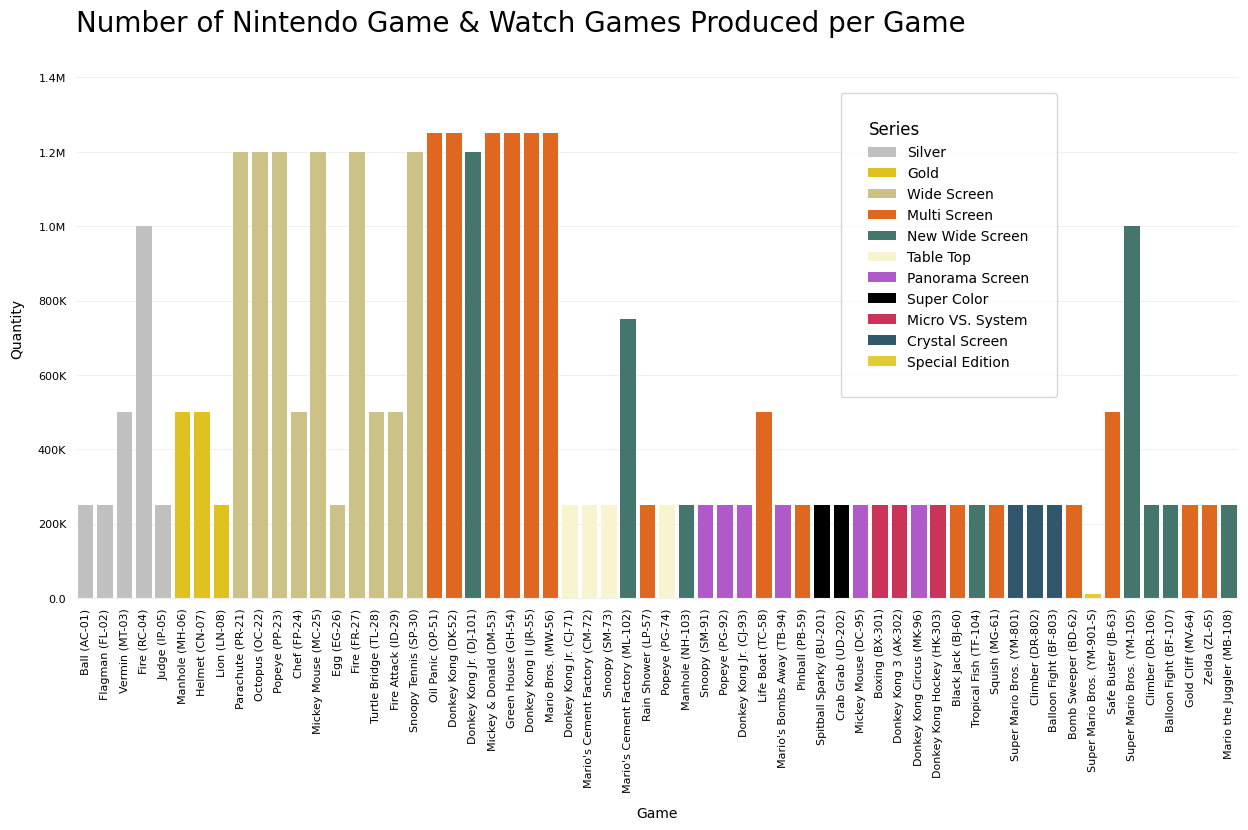

In [26]:
# Create a bar plot visualization showing the number of games produced per game
visualize_games_produced(games_df, max_release_year=1991)

#### Games released

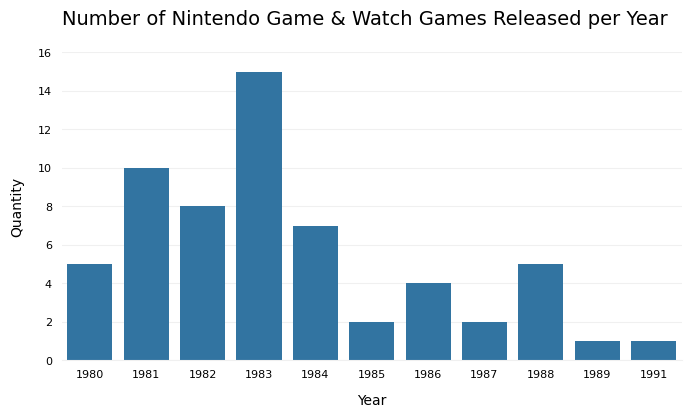

In [27]:
# Create a bar plot visualization showing the number of games released per year
visualize_games_released(games_released_df, max_release_year=1991)

#### Timeline

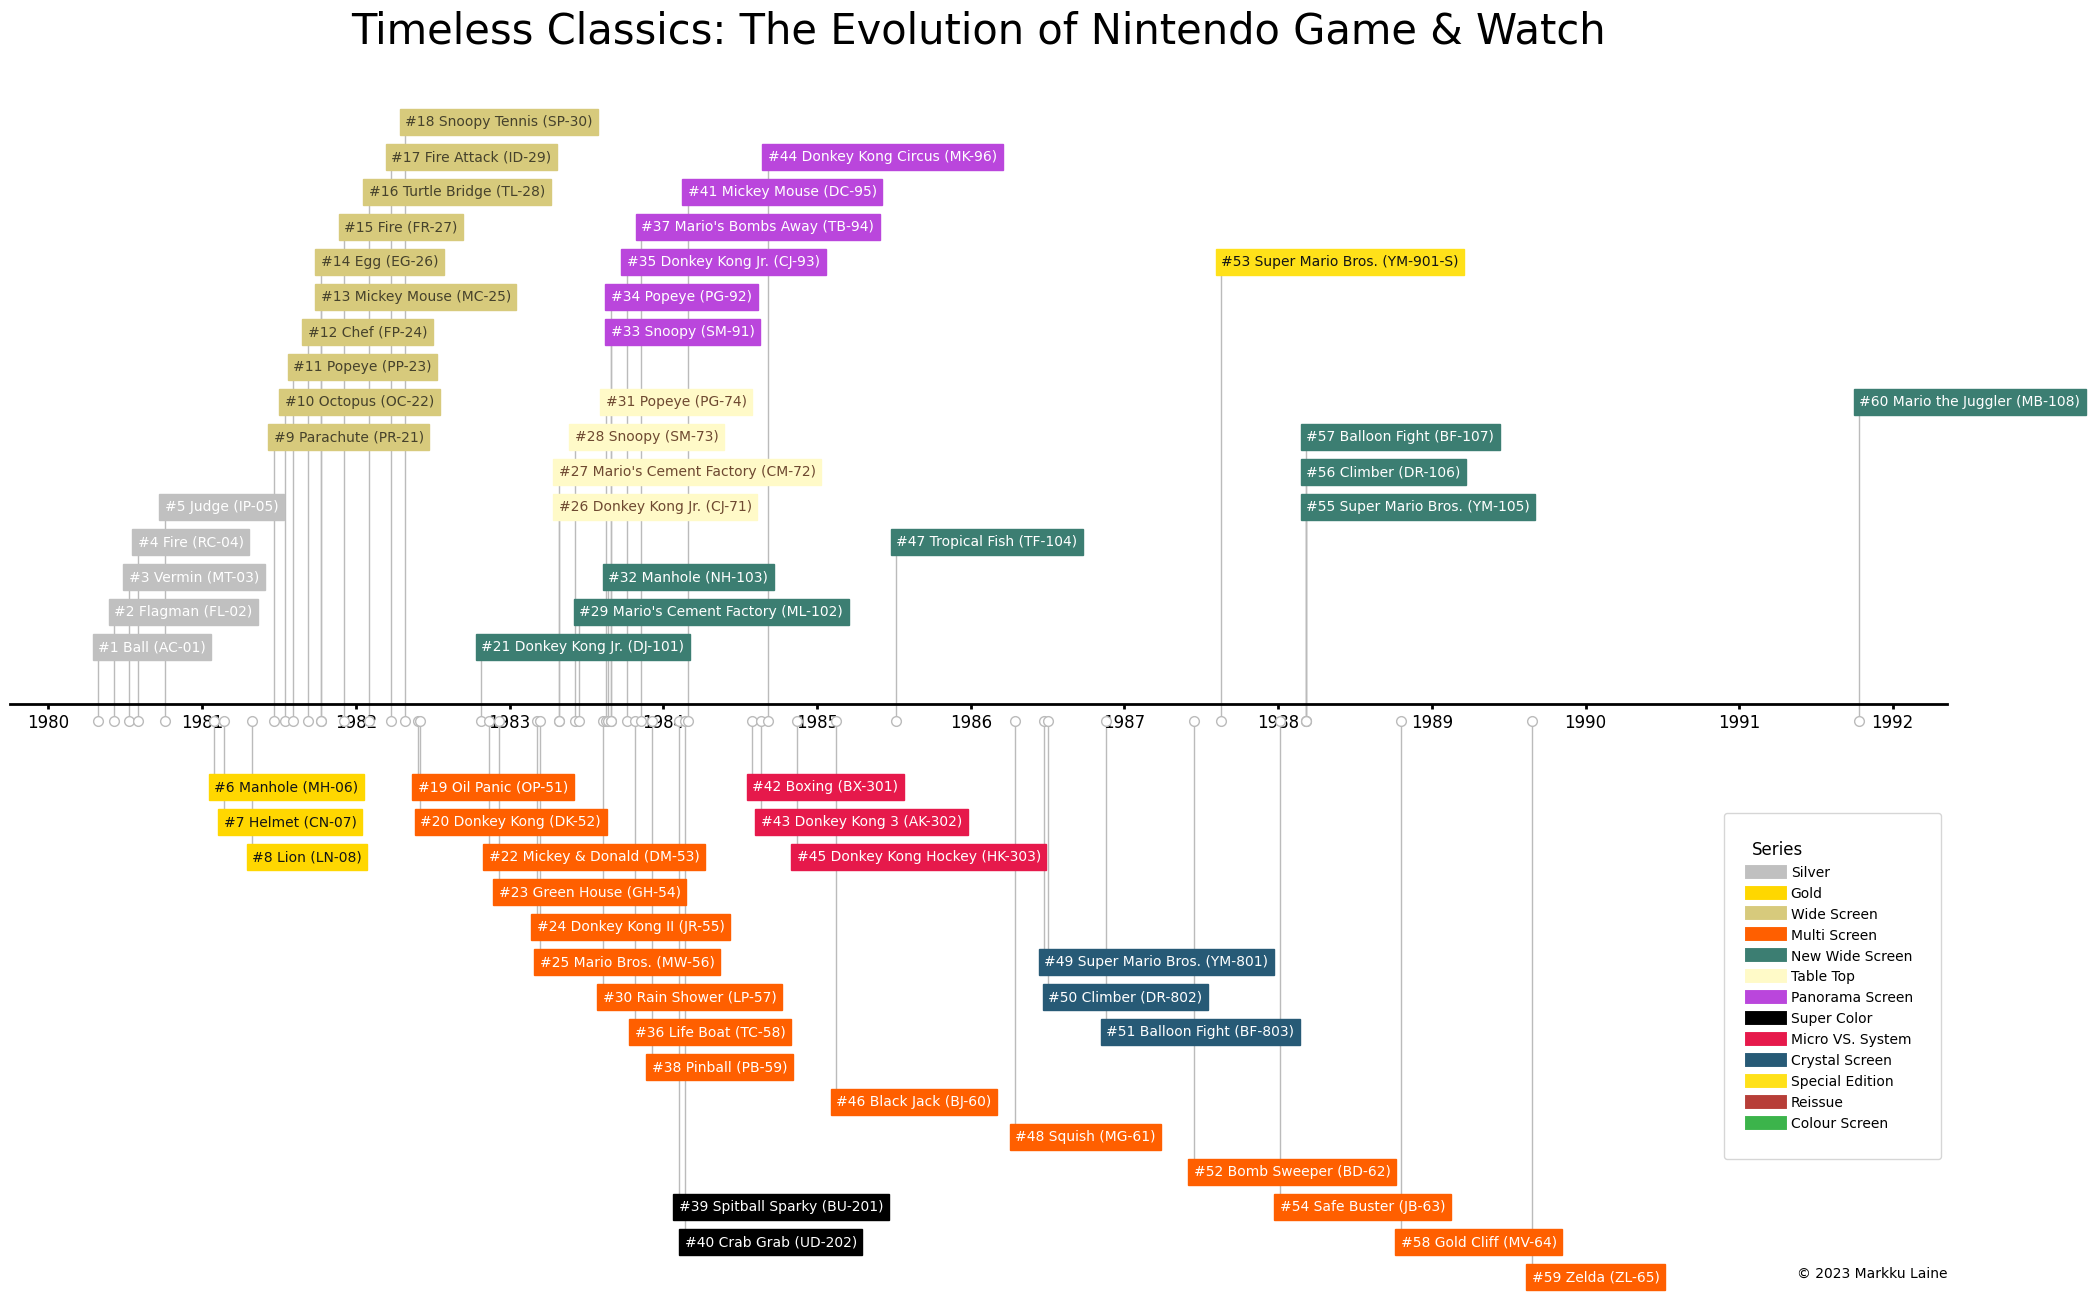

In [28]:
# Create a timeline visualization to display the evolution of Nintendo Game & Watch
visualize_timeline(games_df, max_release_year=1991, auto_levels=False)